# Inspect COMPAS output

* Plot the mass distribution of NSNS
* Animate it over redshift
* Extract essential information to reduce datafile

In [33]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os 
import matplotlib.animation as animation
from scipy import stats
from progressbar import ProgressBar, Percentage, Bar

data_dir = '/mnt/ceph/users/lvanson/CompasOutput/v02.41.06/N1e6_Fiducial_NSNS/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




### Some Util functions

In [26]:

# #########################################
# # Nice little progressbar script 
# # to know how far you are with bootstrapping
# #########################################
# def progressbar(it, prefix="", size=60, file=sys.stdout):
#     count = len(it)
#     def show(j):
#         x = int(size*j/count)
#         file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
#         file.flush()        
#     show(0)
#     for i, item in enumerate(it):
#         yield item
#         show(i+1)
#     file.write("\n")
#     file.flush()

#########################################
# Mchirp
#########################################
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

# Make animations of the NSNS mass distribution as a funciton of redshift

MovieWriter ffmpeg unavailable; using Pillow instead.


<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(46980,)
(3398,)
(3398, 100)
(100,)


/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/scipy/stats/_kde.py:200: RuntimeWarning: invalid value encountered in true_divide
  self._weights /= sum(self._weights)


ValueError: array must not contain infs or NaNs

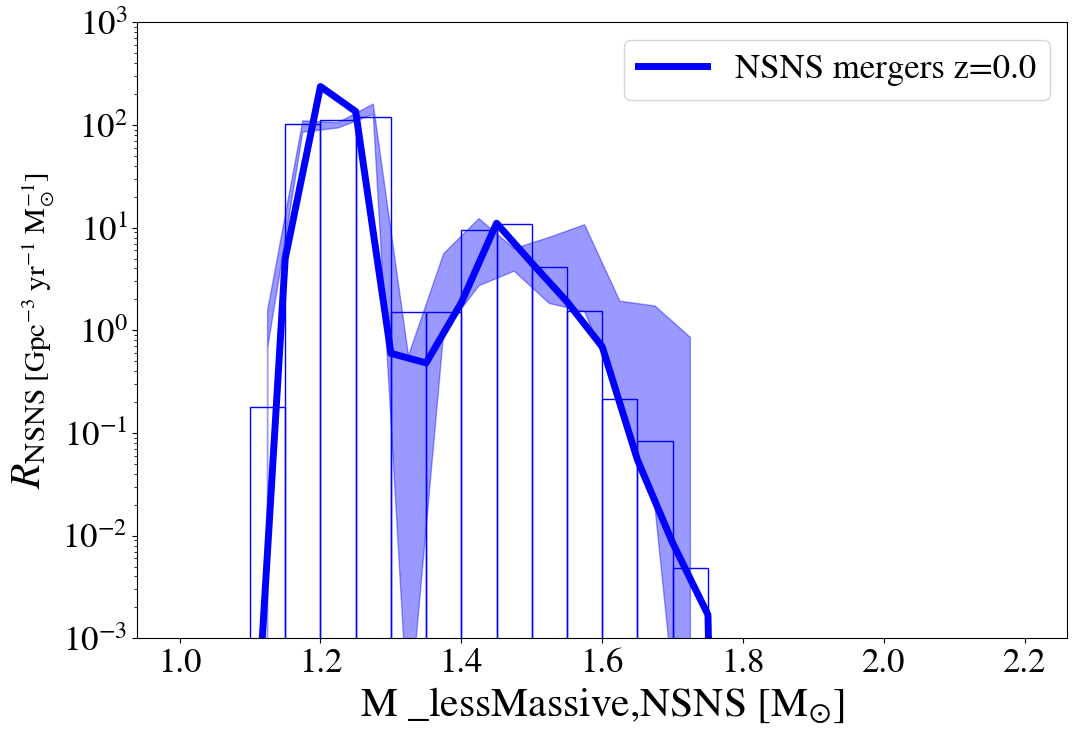

In [41]:

####################################
######   Parameters to set    ######
normalize_by_peak = False # normalize the histogram?
bootstrap         = True # bootstrap the histogram to get sampling noise?
bootstraps        = 10   # number of bootstraps to do
logx              = False # plot the log of the x-axis?
hist_col          = 'blue'
####################################


####################################
# Read the rates data
File = h5.File(data_dir+'/CosmicIntegration/Rate_info.h5', 'r')

# Set the key for the simulation data to analyze
sim_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

# Print the keys in the simulation data
print(File[sim_key].keys())

# Print the shape of each dataset in the simulation data
for key in File[sim_key].keys():
    print(np.shape(File[sim_key][key][()]))

####################################
# Read COMPAS simulation data
dataFile = h5.File(data_dir+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

# Set the key for the double compact object (DCO) data
DCO_key = 'BSE_Double_Compact_Objects'
# Set the list of keys to extract from the DCO data
key_list = ['SEED', 'Mass(1)','Mass(2)','mixture_weight', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

# Extract DCO data to astropy table
DCO = Table()
for key in key_list:
    DCO[key] = dataFile[DCO_key][key][()]
# Calculate the more massive and less massive component masses and chirp mass
DCO['M_moreMassive'] = np.maximum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['M_lessMassive'] = np.minimum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

# Reduce the DCO table to only NSNS that merge in a Hubble time
NSNStable = DCO[File[sim_key]['DCOmask'][()]]

####################################
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bins and x values for the KDE
Mbinwidth = 0.05
mass_key = '_moreMassive' #  'chirp'#'_lessMassive' # 
bins = np.arange(1, 2.2, Mbinwidth)
x_KDE = np.arange(1, 2.2, 0.05)


####################################
# Create the animation function
def animate(i):
    # Clear the axis
    ax.clear()

    # Extract the rates and redshift for the current frame
    rates = File[sim_key]['merger_rate'][()]
    redshifts = File[sim_key]['redshifts'][()]
    redshift_i = i % len(redshifts)

    # Calculate the histogram
    hist, bin_edge = np.histogram(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i], bins=bins)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    norm = 1.
    if normalize_by_peak:
        norm = max(hist / Mbinwidth)

    # Plot the histogram
    y_vals = hist / Mbinwidth / norm
    ax.bar(center_bins, y_vals, width=np.diff(bins),
        alpha=1.0, fill=False, edgecolor= hist_col, lw=1.)

    ########################
    # Bootstrap the histogram to get sampling noise
    if bootstrap:
        indices = np.arange(len(NSNStable[f'M{mass_key}']))
        hist_vals = np.zeros((bootstraps, len(center_bins))) 

        # Add pbar = ProgressBar() and for b in pbar(range( if you want a progress bar
        for b in range(len(hist_vals)): 
            boot_index      = np.random.choice(indices, size=len(indices), replace=True)
            hist_vals[b], _ = np.histogram(NSNStable[f'M{mass_key}'][boot_index], bins=bins, weights=rates[:, redshift_i],density=False)

        if normalize_by_peak:
            norm = max(hist / Mbinwidth)

        # calculate 90% tile
        y_vals = hist_vals / Mbinwidth / norm
        if logx:
            y_vals = y_vals*center_bins
        percentiles = np.percentile(y_vals, [10., 90.], axis=0)

        # Plot the 90% tile
        ax.fill_between(center_bins, percentiles[0],percentiles[1], alpha=0.4, color=hist_col, zorder = 0)


    # Plot the KDE
    kernel = stats.gaussian_kde(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i],  bw_method=0.1)# bw_method='silverman' 'scott')
    KDEy_vals = kernel(x_KDE) * sum(hist) / norm  # re-normalize the KDE
    ax.plot(x_KDE, KDEy_vals, label=f'NSNS mergers z={np.round(redshifts[redshift_i],2)}' , color=hist_col, lw=5)

    # Set the axis labels and limits
    ax.set_xlabel(f'M {mass_key},NSNS '+ '$[\mathrm{M_{\odot}} ]$', fontsize=30)
    ax.set_ylabel('$R_{\mathrm{NSNS} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$', fontsize=30)
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1e3)
    ax.legend()

# Create the animation object
ani = animation.FuncAnimation(fig, animate, frames=len(File[sim_key]['redshifts']), interval=500) 

# Save the animation as a GIF file
# ani.save(data_dir+sim+'/output/Rates/NSNS_merger_rates.gif')
ani.save(f'../plots/NSNS_merger_rates_M{mass_key}.gif')

# Show the animation
plt.show()




# Read and extract essential data to one hdf5 file

In [46]:

# Define the list of simulations to analyze
# simulations = os.listdir(data_dir)
# sim_list = [sim for sim in simulations if sim not in ['EssentialData', 'Grid_Call_Stroopwafel.py']]

data_dir = '/mnt/ceph/users/lvanson/CompasOutput/v02.41.06/'
sim_list = ['N1e6_Fiducial_NSNS']

# Define the list of keys to extract from the DCO data
key_list = ['SEED', 'Mass(1)', 'Mass(2)', 'mixture_weight',
            'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

# Define the name of the output HDF5 file
output_file = 'ReducedCOMPASData.h5'

# Loop over all simulations
with h5.File(data_dir+'/'+output_file, 'w') as f:
    for sim in sim_list:
        # try:
        print('Creating group for simulation:', sim)
        # Create a group for the current simulation
        sim_group = f.create_group(sim)

        # Open the HDF5 file containing the rates data
        File = h5.File(data_dir+sim+'/CosmicIntegration/Rate_info.h5', 'r')

        # Set the key for the simulation data to analyze
        SFRD_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

        # Open the HDF5 file containing the COMPAS simulation data
        dataFile = h5.File(data_dir+sim+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

        # Extract the DCO data for each key in the list
        DCO = Table()
        for key in key_list:
            DCO[key] = dataFile['BSE_Double_Compact_Objects'][key][()]

        # Calculate the more massive and less massive component masses and chirp mass
        DCO['M_moreMassive'] = np.maximum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
        DCO['M_lessMassive'] = np.minimum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
        DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

        # Reduce the DCO table to only NSNS that merge in a Hubble time
        NSNStable = DCO[File[SFRD_key]['DCOmask'][()]]

        # Save the NSNS table to the HDF5 file
        dco_group = sim_group.create_group('NSNS')
        for dco_key in NSNStable.keys():
            dco_group.create_dataset(dco_key, data=NSNStable[dco_key][()])

        # Save the Rate info to the HDF5 file
        rate_group = sim_group.create_group('Rate_info')
        for key in File[SFRD_key].keys():
            rate_group.create_dataset(key, data=File[SFRD_key][key][()])
        # except:
        #     print('error for ', sim)
        #     continue

Creating group for simulation: N1e6_Fiducial_NSNS


In [52]:
data =  h5.File(data_dir+'ReducedCOMPASData.h5', 'r')
print(data['N1e6_Fiducial_NSNS'].keys() )

print(data['N1e6_Fiducial_NSNS']['Rate_info'].keys() )


print(data['N1e6_Fiducial_NSNS']['NSNS'].keys() )


<KeysViewHDF5 ['NSNS', 'Rate_info']>
<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
<KeysViewHDF5 ['M_lessMassive', 'M_moreMassive', 'Mass(1)', 'Mass(2)', 'Mchirp', 'Merges_Hubble_Time', 'SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'mixture_weight']>
